<a href="https://colab.research.google.com/github/nilakshi104/Classifying-name-with-character-level-RNN/blob/master/character_level_RNN_first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from __future__ import unicode_literals,print_function,division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn

In [ ]:
path='/content/drive/My Drive/data/character level RNN/data/names/*.txt'
path1='/content/drive/My Drive/data/character level RNN/data/names/Arabic.txt'

In [ ]:
all_letters=string.ascii_letters+" .,;'"
n_letters=len(all_letters)
n_letters

57

In [ ]:
all_categories=[]
category_lines={}

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

for filename in glob.glob(path):
  category=filename.split('/')[-1].split('.')[0]
  all_categories.append(category)
  lines=readLines(filename)
  category_lines[category]=lines

n_categories = len(all_categories)


In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [ ]:
def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor=torch.zeros(1,n_letters)
  tensor[0,letterToIndex(letter)]=1
  return tensor

print(letterToTensor('c'))

def lineToTensor(line):
  tensor=torch.zeros(len(line),1,n_letters)
  for li,letter in enumerate(line):
    tensor[li,0,letterToIndex(letter)]=1
  return tensor

print(lineToTensor('JONES').size())

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
class RNN (nn.Module):
  def __init__ (self,input_size,hidden_size,output_size):
    super(RNN, self).__init__()   #This is calling the __init__() method of the parent class of RNN, in this case, nn.Module.
    self.hidden_size=hidden_size
    self.i2h=nn.Linear(input_size+hidden_size ,hidden_size)
    self.i2o=nn.Linear(input_size+hidden_size,output_size)
    self.softmax=nn.LogSoftmax (dim=1)
  
  def forward(self,input,hidden):
    # print(input.size(),hidden.size())
    combined=torch.cat((input,hidden),1)
    # print(combined.size())
    hidden=self.i2h(combined)
    output=self.i2o(combined)
    output=self.softmax(output)
    return output,hidden

  def initHidden(self):
    return torch.zeros(1,self.hidden_size)

n_hidden=128
rnn=RNN(n_letters,n_hidden,n_categories)
input=lineToTensor('Albert')
hidden=rnn.initHidden()
output,next_hidden=rnn(input[0],hidden)
output

tensor([[-2.9642, -2.8484, -2.9541, -2.8321, -2.8530, -2.8462, -2.8798, -2.9380,
         -2.9222, -2.8982, -2.9095, -2.9196, -2.9177, -2.9593, -2.9138, -2.7878,
         -2.8723, -2.8320]], grad_fn=<LogSoftmaxBackward>)

In [ ]:
def categoryFromOutput(output):
  top_n,top_i=output.topk(1)
  category_i=top_i.item()
  return all_categories[category_i],category_i
  
categoryFromOutput(output)

('Vietnamese', 15)

In [ ]:

import random

def randomChoice(l):
  return l[random.randint(0,len(l)-1)]

def randomTrainingExample():
  category=randomChoice(all_categories)
  line=randomChoice(category_lines[category])
  category_tensor=torch.tensor([all_categories.index(category)],dtype=torch.long)   #64-bit integer (signed)  {torch.int64 or torch.long}

  line_tensor=lineToTensor(line)
  return category,line,category_tensor,line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', category_tensor)

category = Spanish / line = tensor([3])
category = Japanese / line = tensor([10])
category = German / line = tensor([12])
category = Greek / line = tensor([13])
category = Dutch / line = tensor([17])
category = Greek / line = tensor([13])
category = Italian / line = tensor([7])
category = Korean / line = tensor([14])
category = Irish / line = tensor([2])
category = Scottish / line = tensor([5])


In [ ]:
criterion=nn.NLLLoss()
learning_rate = 0.005
def train(category_tensor,line_tensor):
  hidden=rnn.initHidden()
  rnn.zero_grad()    #Sets gradients of all model parameters to zero.
  for i in range(line_tensor.size()[0]):
    output,hidden=rnn(line_tensor[i],hidden)
  # print(output)
  loss=criterion(output,category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data,alpha=-learning_rate)  # Add parameters' gradients to their values, multiplied by learning rate
    # print(p.grad.data)
  return output,loss.item()

# a,b,c,d=randomTrainingExample()
# # print(c)
# train(c,d)

In [ ]:
import time
import math
n_iters=100000
print_every=5000
plot_every=1000
current_loss=0
all_losses=[]
def timeSince(since):
  now=time.time()
  s=now-since
  m=math.floor(s/60)
  s -= m*60
  return '%dm %ds' %(m,s)

start=time.time()

for iter in range(1,n_iters+1):
  category,line,category_tensor,line_tensor=randomTrainingExample()
  output,loss=train(category_tensor,line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess,guess_i=categoryFromOutput(output)
    correct='✓' if guess == category else '✗ (%s)' %category
    print('%d,%d%% %s %.4f %s / %s %s'%(iter,iter/n_iters*100,timeSince(start),loss,line,guess,correct))

  if iter % plot_every ==0:
    all_losses.append(current_loss/plot_every)
    current_loss=0

5000,5% 0m 7s 2.7594 Bowler / German ✗ (English)
10000,10% 0m 14s 1.8639 Minami / Japanese ✓
15000,15% 0m 21s 1.1534 Cao / Vietnamese ✗ (Chinese)
20000,20% 0m 28s 3.3827 Bagaev / Irish ✗ (Russian)
25000,25% 0m 35s 0.7580 Shi / Chinese ✓
30000,30% 0m 42s 0.5095 Avgerinos / Greek ✓
35000,35% 0m 49s 2.9158 Porras / Greek ✗ (Spanish)
40000,40% 0m 56s 1.5562 Brivio / Portuguese ✗ (Italian)
45000,45% 1m 3s 1.6365 Iwahashi / Arabic ✗ (Japanese)
50000,50% 1m 10s 4.7713 Boutros / Greek ✗ (Arabic)
55000,55% 1m 16s 2.3031 Schwarz / Polish ✗ (Czech)
60000,60% 1m 23s 3.8680 Jones / Dutch ✗ (Scottish)
65000,65% 1m 30s 0.3712 Sarraf / Arabic ✓
70000,70% 1m 37s 3.5380 Maas / Chinese ✗ (Dutch)
75000,75% 1m 44s 0.7097 Kouri / Arabic ✓
80000,80% 1m 50s 0.6798 Chu / Vietnamese ✓
85000,85% 1m 57s 0.4821 Souza / Portuguese ✓
90000,90% 2m 4s 2.2549 Toman / Irish ✗ (Czech)
95000,95% 2m 12s 0.3216 Rheem / Korean ✓
100000,100% 2m 18s 1.6086 Cruz / Spanish ✗ (Portuguese)


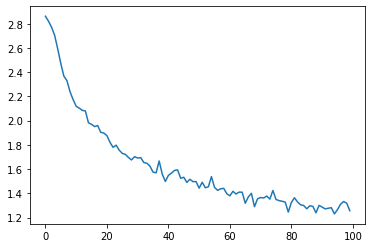

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)

***CONFUSION MATRIX***

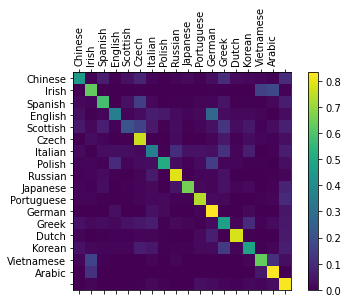

In [ ]:
#keep track of correct guesses in confusion matrix
import matplotlib.ticker as ticker
confusion = torch.zeros(n_categories,n_categories)
n_confussion=10000
def evaluate(line_tensor):
  hidden = rnn.initHidden()
  for i in range(line_tensor.size()[0]):
    output,hidden=rnn(line_tensor[i],hidden)
  return output

for i in range (n_confussion):
  category,line,category_tensor,line_tensor=randomTrainingExample()
  output=evaluate(line_tensor)
  guess,guess_i=categoryFromOutput(output)
  category_i=all_categories.index(category)
  confusion[category_i][guess_i]+=1

for i in range(n_categories):
  confusion[i]  =confusion[i]/confusion[i].sum()

fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels(all_categories,rotation=90)
ax.set_yticklabels(all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [ ]:
def predict(input_line,n_predictions=3):
  print('\n %s'%input_line)
  with torch.no_grad():
    output=evaluate(lineToTensor(input_line))
    topv,topi=output.topk(n_predictions)
    # predictions=[]

    for i in range(n_predictions):
      value=topv[0][i].item()
      category_index=topi[0][i].item()
      print('(%.2f) %s'%(value,all_categories[category_index]))

# predict('Dovesky')
# predict('Jackson')
predict('Wilson')


 Wilson
(-0.16) Scottish
(-2.53) English
(-3.25) Polish
